# Spatial Mapping: Analyzing organization of Neuronal Space based on cell label of interest (POI) and across treamtent groups
### This notebook uses the representative brain model established in a separate python notebook
### The raw dataset is generated from XYZ coordinates based on chon atlas and the SHARQC matlab software

Input needed:
a .csv file of the 'brainpoints' file wanting to be visualized. 
The file will need an 'ap' column, a 'ml' column, and a 'dv' column. 
'groups' column will be used to separate color scale, and can be set by any metric decided by the experimenter. 

Updated 11-27-23 SM
*note- several sections are hard-coded and can be improved by make flexible iteration of datasets
*Final figures complete but more editing is needed, indicated in a few sections

## Notebook analysis: Table of Contents
#### This noteboook is a conitnuation from the "Creating represetnative brain", and only includes the portion of the code necessary for visualizing POI information. See other notebook for full features of representative brain generation and visualization

**_________________________________________________________________________________________________________________________**

# Setup:
1. Import all needed python libraries
2. input file storage information
3. Decide on color coding for group values 

### 1. Import Libraries

In [1]:
#Import all needed libraries 

#Libraries to read and format data
import numpy as np
import pandas as pd
import open3d as o3d

#libraries for genreating figures
%matplotlib ipympl
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
from plotly import tools
from plotly.subplots import make_subplots
import plotly.offline as py
from pandas.api.types import CategoricalDtype 
from collections import Counter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#Libraries for clustering analysis 
from sklearn.cluster import DBSCAN #import density clustering calculations
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import NearestNeighbors 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans #kmean clustering analysis

#Libraries for creating tables
from tabulate import tabulate 
from prettytable import PrettyTable 

#Libraries to compare data and run stats
from scipy.stats import chisquare
import seaborn as sns #visualizing statistics
from itertools import combinations #Calculating groups combinations at later steps


#deactivate warning signs that can spam code later in section due to changes in code updates
import warnings
warnings.filterwarnings("ignore")

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 2. Set path for project file folder and choose data analysis file

**This stage will autofill all save file information, and should be customized for each project and analysis run**

* To find the file path, go into folder library, right click on file, and "copy as path". Paste this path informaation into the correct variables as described 
* Troubleshoot note: to use the "/" not "\", which is interpretted as an error


In [2]:
#DEFINE PATH of project folder
my_path = ("C:/Users/Mullo/Documents")

#Input: files for generating representative brain clusters
my_analysis_file = ("/f_chat_all_python.csv")
my_analysis_file_nocsv = "/f_chat_all_python"
#Input: files for analyzing labelled points of interest (POI)
my_analysis_file_POI = "/f_chatfos_ByTreatment.csv"
my_analysis_file_POI_nocsv = "/f_chatfos_ByTreatment"

#DEFINED project subfolders
output = "/output"
raw_data= "/Raw Data"
output_figures= "/output/Figures"
output_tables= "/output/Tables"
output_datafiles= "/output/DataFiles"

#Setup standard variables for all saved files 
date = pd.to_datetime('now').strftime("%Y-%m-%d")
file_date_name= '({name})'.format(name=date)

#Table with all variables saved 
TableTitle= "Table: Reference table for file input names and paths"
print(TableTitle)
Table_filenames = PrettyTable(["File Description", "File variable name", "File Path"])
Table_filenames.add_row(['File Path on Computer','my_path',my_path])
Table_filenames.add_row(['Input files: rep brain, ', 'my_analysis_file', my_analysis_file])
Table_filenames.add_row(['Input files: points of interest', 'my_analysis_file', my_analysis_file_POI])
Table_filenames.add_row(['Output file for results','output', output])
Table_filenames.add_row(['Subfolder- figure results','output_figures', output_figures])
Table_filenames.add_row(['Subfolder- tables results','output_tables', output_tables])
Table_filenames.add_row(['Subfolder- datafiles results','output_datafiles', output_datafiles])
Table_filenames.add_row(['listed date', 'date', date])
Table_filenames.add_row(['Timestamp for saved file', 'file_date_name', file_date_name])
print(Table_filenames)
#Table_list= list(Table_filenames)
#print(Table_list, type(Table_list))

#Save reference table
#print("Figure saved:", TableTitle)
#print("Saved File Timestamp:", file_date_name)

#save_results_to = (my_path + output)
#Figure name will include the dataset and figure name genreated, as well as timpestamp
#plt.savefig(save_results_to + my_analysis_file_nocsv + "_Table_" + TableTitle + file_date_name + '.png', dpi = 300)

#with open("Output.txt", "w") as text_file:
    #print(f"Table: {TableTitle}", file=text_file)
    
#Text_1= np.savetxt('Output.txt', Table_list, delimiter=' ', newline='\n', header=TableTitle, footer='', comments='# ', encoding=None)
#print(Text_1)

Table: Reference table for file input names and paths
+---------------------------------+--------------------+----------------------------+
|         File Description        | File variable name |         File Path          |
+---------------------------------+--------------------+----------------------------+
|      File Path on Computer      |      my_path       |  C:/Users/Mullo/Documents  |
|     Input files: rep brain,     |  my_analysis_file  |   /f_chat_all_python.csv   |
| Input files: points of interest |  my_analysis_file  | /f_chatfos_ByTreatment.csv |
|     Output file for results     |       output       |          /output           |
|    Subfolder- figure results    |   output_figures   |      /output/Figures       |
|    Subfolder- tables results    |   output_tables    |       /output/Tables       |
|   Subfolder- datafiles results  |  output_datafiles  |     /output/DataFiles      |
|           listed date           |        date        |         2023-12-04         |


### 3. Set up color code for visualzing treatment groups

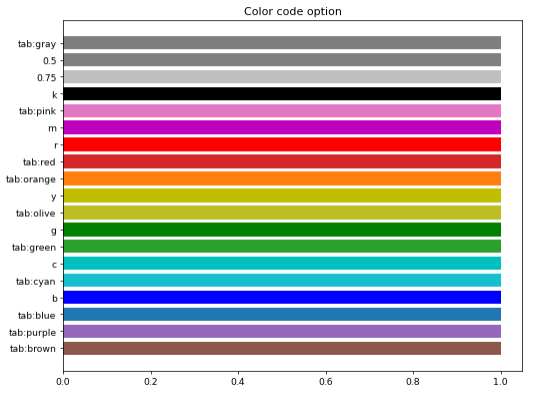

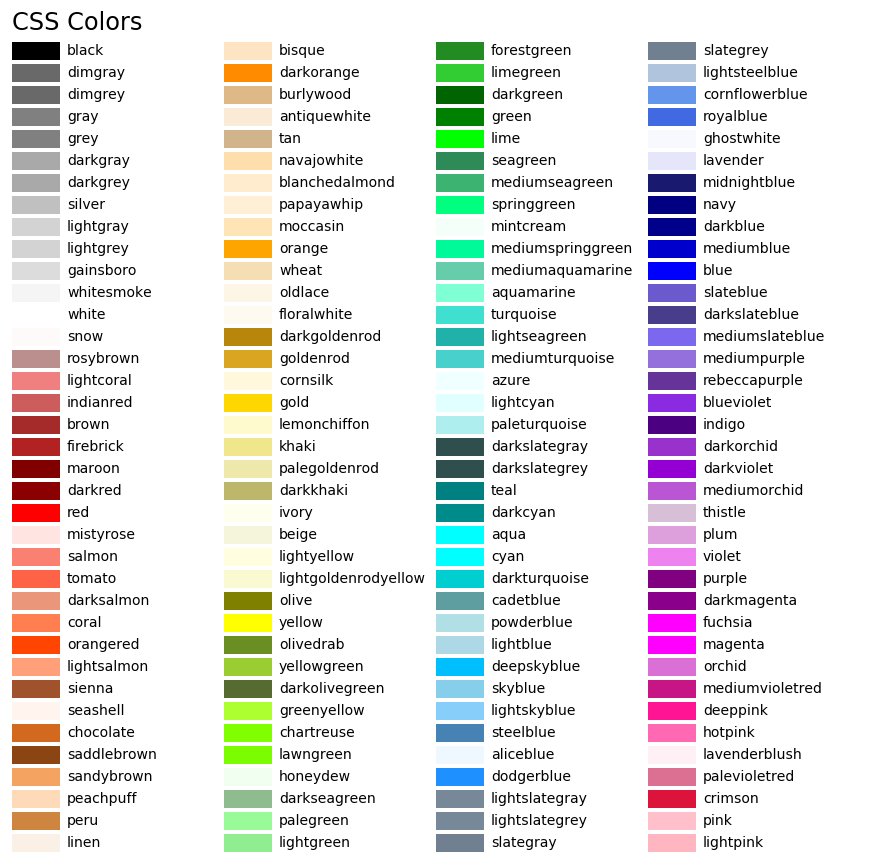

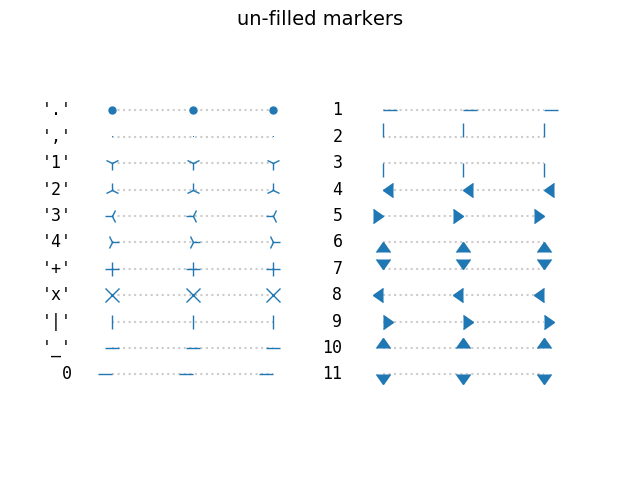

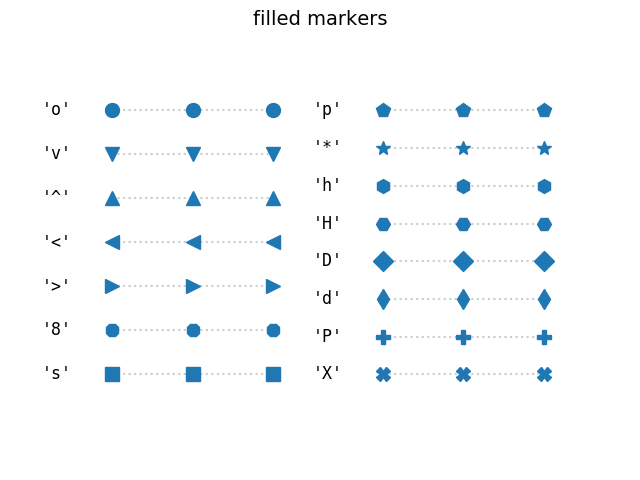

In [3]:
print("How Many Groups?")
num= input()
Total_Number_groups= int(num)+1
print("")

group_number_ID= []
for groupN in range (1,Total_Number_groups):
    group_number_ID.append(groupN)
print("Number of groups set=", len(group_number_ID), group_number_ID)
print("")

print("What is the GroupID number for each treatment category? (note: must match analysis file)")
GroupID_set=[]
for ID in range (1, Total_Number_groups):
    output_ID=input(ID)
    GroupID_set.append(output_ID)
print ("Group ID set=", GroupID_set)
print("")

print("What is Treatment Label for each Group ID? (Note: must exactly match text on analysis file)")
TrLabel_set=[]
for Label in range (1, Total_Number_groups):
    output_label=input(Label)
    TrLabel_set.append(output_label)
print("Treatment Labels set=", TrLabel_set)
print("")

print("What color do you want each group/treatment to be coded? Input text code listed in reference figure")
#todo: CHANGE so that the number index for input matches the labels listed, for easier reference 
color_code= []
for color in range (1, Total_Number_groups):
    output_color = input(color)
    color_code.append(output_color)
print("Color code set=", color_code)

print("What style of marker do you want for the scatter plots?")
marker_style= input()
print("Maker style set:", marker_style)

How Many Groups?


 7



Number of groups set= 7 [1, 2, 3, 4, 5, 6, 7]

What is the GroupID number for each treatment category? (note: must match analysis file)


1 1
2 2
3 3
4 4
5 5
6 6
7 7


Group ID set= ['1', '2', '3', '4', '5', '6', '7']

What is Treatment Label for each Group ID? (Note: must exactly match text on analysis file)


1 1d sal
2 5d sal
3 15d sal
4 1d 2et
5 5d 2et
6 15d 2et
7 1d 4et


Treatment Labels set= ['1d sal', '5d sal', '15d sal', '1d 2et', '5d 2et', '15d 2et', '1d 4et']

What color do you want each group/treatment to be coded? Input text code listed in reference figure


1 grey
2 darkgrey
3 slategrey
4 deepskyblue
5 teal
6 mediumpurple
7 tab:red


Color code set= ['grey', 'darkgrey', 'slategrey', 'deepskyblue', 'teal', 'mediumpurple', 'tab:red']
What style of marker do you want for the scatter plots?


 o


Maker style set: o


### Create reference tables of parameters set during setup- rerun setup steps if anything is inaccurate

Legend treatment colorcode
+----------+-----------------+--------------+
| Group ID | Treatment Label |  color code  |
+----------+-----------------+--------------+
|    1     |      1d sal     |     grey     |
|    2     |      5d sal     |   darkgrey   |
|    3     |     15d sal     |  slategrey   |
|    4     |      1d 2et     | deepskyblue  |
|    5     |      5d 2et     |     teal     |
|    6     |     15d 2et     | mediumpurple |
|    7     |      1d 4et     |   tab:red    |
+----------+-----------------+--------------+

Location of saved file: C:/Users/Mullo/Documents/output/Figures


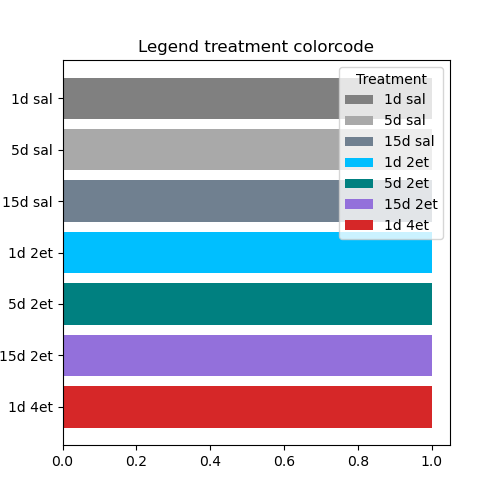

In [4]:
#Create table summarize 
FigureTitle="Legend treatment colorcode"
FigureDetail= 'Legend treatment colorcode'
TableTitle= 'Legend treatment colorcode'
print(TableTitle)
Table_colorcode= PrettyTable(['Group ID', 'Treatment Label', 'color code'])
for more in range (0,Total_Number_groups-1):
    Table_colorcode.add_row([GroupID_set[more], TrLabel_set[more], color_code[more]])
print(Table_colorcode)

#Create a dataframe to store these reference values 
setup_RefGroup= pd.DataFrame({"Group ID":GroupID_set, "Treatment Label":TrLabel_set, "Color Code":color_code})
print("")

#Creating a simple bar graph to visualize each treatment group
fig_legend, ax_rl = plt.subplots(figsize=(5,5))
bar_labels = TrLabel_set
bar_colors = color_code
bar_ref=ax_rl.barh(GroupID_set, 1, label=bar_labels, color=bar_colors, align='center')
y_length= []
for grow in range (0, len(GroupID_set)):
    y_length.append(1)
#ref_scatter= ax_rl.scatter(y_length, GroupID_set, label=bar_labels, color=bar_colors, marker= marker_style)
ax_rl.set_title(FigureTitle)
ax_rl.set_yticks(GroupID_set, labels= bar_labels)
ax_rl.invert_yaxis()
#legend= ax_rl.legend(title='Treatment', bbox_to_anchor=(1, 1), bbox_transform=fig_legend.transFigure)
ax_rl.legend(loc='upper right', title='Treatment', bbox_transform=fig_legend.transFigure)
plt.figure(fig_legend)

save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)


**_________________________________________________________________________________________________________________________**

# Condensed analysis proceudres: only code necessary for calcuations and variable definitions

Generate representative brain [condensed]
* This portion is an abbreviated version of the full "generating representative brain" notebook, and only inlcudes the portion that is needed for the analysis in part 2. 
* This part does not inlcude any visuals, except those necessary for quality check 

## condensed: Part 1 generating representative brain

#### Dataframe and dataset integration

In [5]:
df2 = pd.read_csv(my_path + raw_data+ my_analysis_file) #Import files to pandas dataframe from local computer path
print("File input:", my_analysis_file)

#create a column with a datapoint ID so all future analysis points are joined to the right datapoint 
datapoint_ID=[]
for boom in range (0, len(df2)):
    input_asnum= int(boom)
    datapoint_ID.append(input_asnum)
df2["datapoint ID"]= datapoint_ID
print(df2)

dataset_xyz = df2[['ap','dv','ml']].values #Create 3D matrix for analysis #, 'datapoint ID']

File input: /f_chat_all_python.csv
     animal treatment    ap    dv    ml  groups  datapoint ID
0       F10   15d 2et -5.08  4.29 -1.11       6             0
1       F10   15d 2et -5.08  4.33 -1.11       6             1
2       F10   15d 2et -5.07  4.35 -1.07       6             2
3       F10   15d 2et -5.07  4.44 -1.06       6             3
4       F10   15d 2et -5.07  4.35 -1.05       6             4
...     ...       ...   ...   ...   ...     ...           ...
5037     F5    5d sal -4.35  4.12  2.03       2          5037
5038     F5    5d sal -4.35  4.12  2.06       2          5038
5039     F5    5d sal -4.35  4.27  2.06       2          5039
5040     F5    5d sal -4.35  4.29  2.06       2          5040
5041     F5    5d sal -4.35  4.28  2.14       2          5041

[5042 rows x 7 columns]


#### cluster calculatons and running kmeans clustering model

In [6]:
cell_number = df2.groupby(['animal'])['groups'].count() 
cell_number_listed = cell_number.tolist()
animal_listed = df2['animal'].unique()

#Manually input number of clusters based on the updated average 
cluster_number= round(cell_number.mean())

#Input cluster number into the model and generate a k-means clustering model from the XYZ coordiantes
km_model = KMeans(n_clusters = cluster_number, init = "k-means++", max_iter = 300, n_init = 20, random_state = 0)
y_clusters = km_model.fit(dataset_xyz)
model_clusters = y_clusters.fit_predict(dataset_xyz)

#Add cluster ID to the main dataset
print("Updated Dataset with Cluster Information from", my_analysis_file)
data_cluster= pd.DataFrame({'section_ap':dataset_xyz[:,0], 'dv':dataset_xyz[:,1], 'ml':dataset_xyz[:,2], 'km_cluster_id':km_model.labels_})
data_clustersort= data_cluster.sort_values(by='km_cluster_id')

#cluster centroid and dataset
#Import information on cluster centroids 
centroids = km_model.cluster_centers_

#create list of all cluster IDs
km_sortclusterID = data_cluster.sort_values(by=['km_cluster_id'])
k_model_clusterID= km_sortclusterID['km_cluster_id'].unique().tolist()
print("Total number of clusters=", len(k_model_clusterID))

#create centroid dataset for future analysis 
km_cent=pd.DataFrame({'cluster ID':k_model_clusterID, 'ap':centroids[:,0], 'dv':centroids[:,1], 'ml':centroids[:,2]})
km_cent.index=km_cent['cluster ID']
print(km_cent.head(10))

Updated Dataset with Cluster Information from /f_chat_all_python.csv
Total number of clusters= 720
            cluster ID        ap        dv        ml
cluster ID                                          
0                    0 -4.697143  3.674286  0.547143
1                    1 -4.747500  4.162500 -0.920000
2                    2 -4.343077  4.144615  1.301538
3                    3 -4.620000  4.115833 -1.427500
4                    4 -4.764000  4.399000  0.872000
5                    5 -4.887692  3.721538 -0.517692
6                    6 -4.278462  4.434615 -1.210000
7                    7 -4.532727  4.182727  1.480000
8                    8 -5.030000  4.300000 -0.495000
9                    9 -4.887500  3.982500  0.415833


***-----------------------------------------------------------------------------------------------------------------------***

## Condensed part 2-3: classify predicted cluster ID for POI

#### condensed: datasets and variables needed for figure plotting and analysis

In [7]:
#Import files to pandas dataframe from local computer path
data_POI= pd.read_csv(my_path + raw_data + my_analysis_file_POI)

#Important variables for figure 
colorcode_gID= setup_RefGroup['Group ID'].unique().astype('str')
colorcode_Treat= setup_RefGroup['Treatment Label'].unique().astype('str')
colorcode_color = setup_RefGroup['Color Code'].tolist()
#Define anterior-posterior range and splitting (POI)
ap_POIlisted= data_POI.sort_values(by=['ap'])['ap'].unique()
ap_POImin= min(ap_POIlisted)
ap_POImax= max (ap_POIlisted)
ap_POIrange= abs(ap_POImax-ap_POImin)
#axis based on POI dataset
ml_POI= data_POI["ml"].tolist()
ap_POI= data_POI["ap"].tolist()
dv_POI= data_POI["dv"].tolist()
min_POIx= round(min(ml_POI))
max_POIx= round(max(ml_POI))
min_POIy= round(min(dv_POI))
max_POIy= round(max(dv_POI))

#Define anterior-posterior range and splitting (rep brain)
ap_kmlisted= km_cent.sort_values(by=['ap'])['ap'].unique()
ap_kmmin= min(ap_kmlisted)
ap_kmmax= max (ap_kmlisted)
ap_kmrange= abs(ap_kmmax-ap_kmmin)
#axis based on rep brain model 
km_ml= km_cent['ml'].tolist()
km_ap= km_cent['ap'].tolist()
km_dv= km_cent['dv'].tolist()
min_kmx= round(min(km_ml))
max_kmx= round(max(km_ml))
min_kmy= (min(km_dv))
max_kmy= (max(km_dv))

#min and max of all values 
mina_ml= min(ml_POI + km_ml)
maxa_ml= round(max(ml_POI + km_ml))
mina_dv=min((dv_POI) + (km_dv))
maxa_dv=round(max(dv_POI + km_dv))
mina_ap=min(ap_POI + km_ap)
maxa_ap=round(max(ap_POI + km_ap))

#visualize: cross section figure
number_subplots=4 
find_step= (ap_kmrange)/(number_subplots) 
ap_all_cross= [] 
for letsgo in range (0, number_subplots+1):
    ap_value= ap_kmmin + (letsgo*find_step)
    ap_all_cross.append(ap_value)
#Create subplot and subplot reference variables 
sct_ref= []
for expand in range (0, number_subplots+1):
    sct_ref.append(expand)
#Setup the section varaible names 
sct_minap= []
sct_maxap= []
for identify in range (0, len(sct_ref)-1):
    min_ref= round(ap_all_cross[identify], 2)
    sct_minap.append(min_ref)
for shout in range (1, len(sct_ref)):
    max_ref= round(ap_all_cross[shout], 2)
    sct_maxap.append(max_ref)
#create reference to cross sections
sct1= [sct_minap[0], sct_maxap[0]]
sct2= [sct_minap[1], sct_maxap[1]]
sct3= [sct_minap[2], sct_maxap[2]]
sct4=[sct_minap[3], sct_maxap[3]]

#Two datasets to split- one for the representative brain, and one for the POI dataframe
subplot_kmsct=[]
for hip in range (0, len(km_cent)):
    ref_ap= round(km_ap[hip], 3)
    if (ref_ap>=sct1[0]) and (ref_ap<= sct1[1]):
        subplot_kmsct.append(1)
    elif (ref_ap>= sct2[0]) and (ref_ap<= sct2[1]):
        subplot_kmsct.append(2)
    elif (ref_ap>= sct3[0]) and (ref_ap<= sct3[1]):
        subplot_kmsct.append(3)
    elif (ref_ap>= sct4[0]) and (ref_ap<= sct4[1]):
        subplot_kmsct.append(4)
    else:
        subplot_kmsct.append(0)
km_cent['xsct ID']= subplot_kmsct


#repeat for L or R hemisphere values 
subplot_kmhemi=[]
for frog in range (0, len(km_cent)):
    ref_ml= km_ml[frog]
    if ref_ml >= 0:
        subplot_kmhemi.append('R')
    elif ref_ml <=0:
        subplot_kmhemi.append('L')
    else:
        subplot_kmhemi.append('x')
km_cent['hemisphere']=subplot_kmhemi

subplot_POIsct=[]
for hop in range (0, len(data_POI)):
    ref_ap2= round(data_POI['ap'][hop], 3)
    if (ref_ap2>=sct1[0]-1) and (ref_ap2<= sct1[1]):
        subplot_POIsct.append(1)
    elif (ref_ap2>= sct2[0]) and (ref_ap2<= sct2[1]):
        subplot_POIsct.append(2)
    elif (ref_ap2>= sct3[0]) and (ref_ap2 <= sct3[1]):
        subplot_POIsct.append(3)
    elif (ref_ap2>= sct4[0]) and (ref_ap2<= sct4[1]):
        subplot_POIsct.append(4)
    else:
        subplot_POIsct.append(0)
data_POI['xsct ID']= subplot_POIsct

subplot_POIhemi=[]
for pig in range (0, len(data_POI)):
    ref_ml= ml_POI[pig]
    if ref_ml >= 0:
        subplot_POIhemi.append('R')
    elif ref_ml <=0:
        subplot_POIhemi.append('L')
    else:
        subplot_POIhemi.append('x')
data_POI['hemisphere']=subplot_POIhemi

### condensed: split dataframe information between cross section and hemisphere for easier plotting

In [8]:
#Filter all datasets out by different sections for histograms

km_sct1= km_cent.groupby('xsct ID').get_group(1)
km_sct1L= km_sct1.groupby('hemisphere').get_group('L')
km_sct1R= km_sct1.groupby('hemisphere').get_group('R')

km_sct2= km_cent.groupby('xsct ID').get_group(2)
km_sct2L= km_sct2.groupby('hemisphere').get_group('L')
km_sct2R= km_sct2.groupby('hemisphere').get_group('R')

km_sct3= km_cent.groupby('xsct ID').get_group(3)
km_sct3L= km_sct3.groupby('hemisphere').get_group('L')
km_sct3R= km_sct3.groupby('hemisphere').get_group('R')

km_sct4= km_cent.groupby('xsct ID').get_group(4)
km_sct4L= km_sct4.groupby('hemisphere').get_group('L')
km_sct4R= km_sct4.groupby('hemisphere').get_group('R')

POI_sct1= data_POI.groupby('xsct ID').get_group(1)
POI_sct1L= POI_sct1.groupby('hemisphere').get_group('L')
POI_sct1R= POI_sct1.groupby('hemisphere').get_group('R')
grlist_P1L=POI_sct1L.groupby('groups')['groups'].unique()
grlist_P1R=POI_sct1R.groupby('groups')['groups'].unique()

POI_sct2= data_POI.groupby('xsct ID').get_group(2)
POI_sct2L= POI_sct2.groupby('hemisphere').get_group('L')
POI_sct2R= POI_sct2.groupby('hemisphere').get_group('R')
grlist_P2L=POI_sct2L.groupby('groups')['groups'].unique()
grlist_P2R=POI_sct2R.groupby('groups')['groups'].unique()

POI_sct3= data_POI.groupby('xsct ID').get_group(3)
POI_sct3L= POI_sct3.groupby('hemisphere').get_group('L')
POI_sct3R= POI_sct3.groupby('hemisphere').get_group('R')
grlist_P3L=POI_sct3L.groupby('groups')['groups'].unique()
grlist_P3R=POI_sct3R.groupby('groups')['groups'].unique()

POI_sct4= data_POI.groupby('xsct ID').get_group(4)
POI_sct4L= POI_sct4.groupby('hemisphere').get_group('L')
POI_sct4R= POI_sct4.groupby('hemisphere').get_group('R')
grlist_P4L=POI_sct4L.groupby('groups')['groups'].unique()
grlist_P4R=POI_sct4R.groupby('groups')['groups'].unique()

print("step complete!")

step complete!


### condensed: generate POI predicted cluster ID by input dataset into representative brain model

In [9]:
#Load the created kmeans model 
km_model #The variable that stores the model itself 
model_clusters #Defined cluster groups of all original points in model
km_cent #Defined centroids from model

#Create matrix of labelled clusters to be tested in model 
POI_xyz = data_POI[['ap','dv','ml']].values
#Use established model to output predicted cluster values for new dataset
#Create matrix of labelled clusters to be tested in model 
POI_xyz = data_POI[['ap','dv','ml']].values

#Use established model to output predicted cluster values for new dataset
predict_POI_cluster = km_model.predict(POI_xyz)
predict_cluster= predict_POI_cluster.tolist()

#Update the dataframe with the cluster ID values
#Add cluster ID to the main dataset
print("Updated Dataset with Cluster Information from", my_analysis_file_POI)
POIdata_cluster= pd.DataFrame({'section_ap':POI_xyz[:,0], 'dv':POI_xyz[:,1], 'ml':POI_xyz[:,2], 'treatment':data_POI['treatment'],'groups':data_POI['groups'], 'predicted cluster id':predict_cluster}) 
POIdata_cluster.index.name= "datapoint"
POIdata_cluster

#split cluster ID by treatment groups 
clusterID_all= POIdata_cluster['predicted cluster id']

#Input cluster coordinates for predicted ID
model_cID= km_cent['cluster ID']
model_cap= km_cent['ap']
model_cml=km_cent['ml']
model_cdv=km_cent['dv']

#generate iterable output coordinates for each cluster ID
c_ID= []
c_ap= []
c_ml=[]
c_dv=[]
for point in range (0, len(clusterID_all)):
    datapoint_eval= clusterID_all[point]
    for mpnt in range (0, len(model_cID)):
        compare= model_cID[mpnt]
        temp_ap= model_cap[mpnt]
        temp_ml= model_cml[mpnt]
        temp_dv= model_cdv[mpnt]
        if datapoint_eval == compare:
            c_ID.append(compare)
            c_ap.append(temp_ap)
            c_ml.append(temp_ml)
            c_dv.append(temp_dv)
        else:
            pass

#add cluster centroid into dataframe 
POIdata_cluster["centroid ID"]= c_ID
POIdata_cluster["centroid ap"]= c_ap
POIdata_cluster["centroid ml"]= c_ml
POIdata_cluster["centroid dv"]= c_dv
print(POIdata_cluster)

Updated Dataset with Cluster Information from /f_chatfos_ByTreatment.csv
           section_ap    dv    ml treatment  groups  predicted cluster id  \
datapoint                                                                   
0               -4.71  4.29 -1.13    1d 2et       4                   399   
1               -4.71  4.12 -0.97    1d 2et       4                     1   
2               -4.71  4.05 -0.93    1d 2et       4                   341   
3               -4.71  4.00 -0.83    1d 2et       4                   253   
4               -4.71  3.79 -0.77    1d 2et       4                   324   
...               ...   ...   ...       ...     ...                   ...   
602             -4.35  4.39  1.28    5d sal       2                   209   
603             -4.35  4.56  1.35    5d sal       2                    65   
604             -4.35  4.31  1.41    5d sal       2                   104   
605             -4.35  4.51  1.42    5d sal       2                    65   
606

## condensed part 2: POI cluster classification split by treatment, and analyzing between-treatments

### condensed: calculations and variables to analyzed predicted cluster datasets

In [10]:
#Create a reference list of all groups and the treatments they correspond 
data_POI_sortbyGroup =  data_POI.sort_values('groups')
datacount_splitbyGroup = data_POI_sortbyGroup.groupby('groups')['animal'].count()
datacount_list= datacount_splitbyGroup.tolist()

#Update reference dataframe from setup step
setup_RefGroup["N datapoints in treatment"]= datacount_list

#Calculate number of clusters covered for each treatment group
cluster_unique = []
for cl in range (min(group_number_ID), max(group_number_ID)+1):
    OnlyGroup= POIdata_cluster.loc[(POIdata_cluster.groups == cl)]
    unique_numCluster= OnlyGroup['predicted cluster id'].unique()
    Group_numCluster=len(unique_numCluster.tolist())
    cluster_unique.append(Group_numCluster)

#Update reference Dataframe
setup_RefGroup["N cluster in treatment"]= cluster_unique
setup_RefGroup.index=setup_RefGroup['Group ID']

#Create a list of all clusters predicted without duplicates
POIcID_listed= sorted(POIdata_cluster['predicted cluster id'].unique().tolist())

#Calcuate the total number of datapoints in each predicted cluster
POIdata_sorted=POIdata_cluster.sort_values(by=['predicted cluster id'])
POIc_nPoints= POIdata_sorted.groupby(['predicted cluster id'])['predicted cluster id'].count().tolist()
#print(len(POIc_nPoints))

#calculate the total number of treatment groups included in each predicted cluster
POIc_nGroups= POIdata_sorted.groupby(['predicted cluster id'])['groups'].nunique().tolist()
#print(len(POIc_nGroups))

#List the treatments or group number in each cluster 
#print(POIdata_sorted)
POIc_groupList= POIdata_sorted.groupby('predicted cluster id')['groups'].unique()

#Create dataframe 
POIdata_clusterInfo= pd.DataFrame({"pred cluster ID":POIcID_listed, "N datapoints":POIc_nPoints, "N groups":POIc_nGroups, "groups listed":POIc_groupList})
POIdata_clusterInfo.head(10)

,pred cluster ID,N datapoints,N groups,groups listed
predicted cluster id,,,,
1,1,2,2,"[4, 5]"
2,2,2,2,"[4, 3]"
4,4,3,2,"[2, 5]"
6,6,5,2,"[3, 5]"
7,7,1,1,[2]
9,9,3,1,[3]
11,11,2,2,"[5, 2]"
14,14,1,1,[1]
16,16,4,3,"[5, 3, 4]"


____________________________________________________________________________

# Part 4: Analyze the number of treatments represented in each cluster and visualize distribution across representative brain and treatment comparrisons


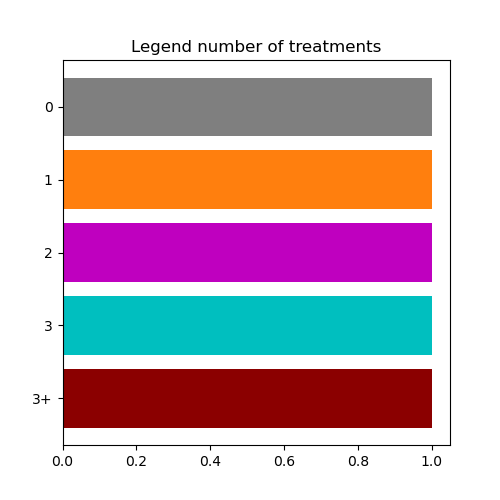

Location of saved file: C:/Users/Mullo/Documents/output/Figures


In [11]:
#Create the variables for the color scale and marker size scale for figure 
FigureTitle=('Legend number of treatments')
FigureDetail= 'Legend for nTreat'

#decide colors for treatment number categories
no_treat= 'tab:grey'
treat_1= 'tab:orange'
treat_2= 'm'
treat_3= 'c'
treat_plus= 'darkred'

#list of all cluster IDs to compare 
all_cluster_id= km_cent['cluster ID'].tolist()
#Create a list of all clusters that are included with POI prediction 
POI_cluster_id= POIdata_clusterInfo['pred cluster ID'].tolist()

#creat a list of all 'N groups' values in ROI predicted clusters
POI_cluster_ngroup= POIdata_clusterInfo['N groups'].values

#Create a checklist of number of datapoints for values in predicted cluster 
ngroups_checklist=[]
for poppy in range (0, len(all_cluster_id)):
    model_tocheck= all_cluster_id[poppy]
    check_POIlist= POI_cluster_id.count(model_tocheck)
    if check_POIlist >0:
        for daisy in range (0, len(POI_cluster_id)):
            POI_check= POI_cluster_id[daisy]
            ngroup_input= POI_cluster_ngroup[daisy]
            if POI_check ==model_tocheck:
                ngroups_checklist.append(ngroup_input)
            else:
                pass
    else:
        ngroups_checklist.append(int(0))

#After creating the list with ngroups based on cluster ID, generate a color scale:
full_colorcode=[]
for peony in range (0, len(ngroups_checklist)):
    check_input_values= ngroups_checklist[peony]
    if check_input_values == 0:
        full_colorcode.append(no_treat)
    elif check_input_values == 1:
        full_colorcode.append(treat_1)
    elif check_input_values == 2:
        full_colorcode.append(treat_2)
    elif check_input_values == 3:
        full_colorcode.append(treat_3)
    else:
        full_colorcode.append(treat_plus)

#Size each datapoint based on the number of datapoints present in the cluster 
POI_cluster_npoint= POIdata_clusterInfo['N datapoints'].values

#create an array for graphing 
markersize_checklist=[]
for poppy in range (0, len(all_cluster_id)):
    model_tocheck= all_cluster_id[poppy]
    check_POIlist= POI_cluster_id.count(model_tocheck)
    if check_POIlist >0:
        for daisy in range (0, len(POI_cluster_id)):
            POI_check= POI_cluster_id[daisy]
            npoint_input= POI_cluster_npoint[daisy]*2
            if POI_check ==model_tocheck:
                markersize_checklist.append(npoint_input)
            else:
                pass
    else:
        markersize_checklist.append(int(1))

#Create a color scale for legend 
#Creating a simple bar graph to visualize each treatment group 
fig_nTreatlegend, ax_nTl = plt.subplots(figsize=(5,5))
NumberOfGroups=[0, 1, 2, 3, '3+']
tickNumber=[0, 1, 2, 3, 4]
ColorScale=[no_treat, treat_1, treat_2, treat_3, treat_plus]
ax_nTl.barh(tickNumber, 1, label=NumberOfGroups, color=ColorScale, align='center')
ax_nTl.set_title(FigureTitle)
ax_nTl.set_yticks(tickNumber, labels= NumberOfGroups)
ax_nTl.invert_yaxis()
#ax_rl.bar_label(bar_labels)
legend= ax_nTl.legend(title='number of treatments', bbox_to_anchor=(1, 1), bbox_transform=fig_nTreatlegend.transFigure)
plt.show()

#________________________________________________________________
save_results_to = my_path + output_figures
print("Location of saved file:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)

### Generate data: number of treatments in each cluster and related calculations for plotting

In [12]:
#Determine the max number of group combinations in a cluster 
Ngroup_max= max(POIdata_clusterInfo['N groups'])
#Main dataframe to organize-
#print(POIdata_clusterInfo)

#Create new dataframes depending on how many combinations there are 
#note- all variables (dataframe) are in order by cluster ID
grouped= POIdata_clusterInfo.groupby(POIdata_clusterInfo['N groups'])
just_nGroups=POIdata_clusterInfo['N groups'].tolist()
just_clusters= POIdata_clusterInfo['pred cluster ID'].tolist()
listed_group=POIdata_clusterInfo['groups listed'].tolist()

#creating a list of the cluster ID that have one, two, three, or more group ID included ("nTreat category") 
single_treat= []
single_list=[]
double_treat= []
double_list=[]
triple_treat= []
triple_list=[]
more_treat= []
more_list=[]

for cheerio in range (0, len(just_nGroups)):
    test_value= just_nGroups[cheerio]
    cluster_forinput= just_clusters[cheerio]
    glist_forinput= listed_group[cheerio]
    if test_value == 1:
        single_treat.append(cluster_forinput)
        single_list.append(glist_forinput)
    elif test_value == 2:
        double_treat.append(cluster_forinput)
        double_list.append(glist_forinput)
    elif test_value == 3:
        triple_treat.append(cluster_forinput)
        triple_list.append(glist_forinput)
    else:
        more_treat.append(cluster_forinput)
        more_list.append(glist_forinput)

#Create two identical (in size) arrays by the cluster ID in each nTreat category, and the group ID included for that nTreat category
#because the previous for loop just focused on categorizing the clusters, the input is listed as if there is only one datapoint for that cluster.
#the point of this forloop is to create a list of each individual datapoint, so the duplicate values of clusters can be better analysed. 
#for example- clusterID 11 (in previous for loop) only is recorded once. However, it has two occurances not just one, so it needs to be counted twice. 
#the output values of "_reflist" is the best variable to then count specific labels by. It's necessary step from the first step.
single_check=[]
single_group=[]
double_check=[]
double_group=[]
triple_check=[]
triple_group=[]
more_check=[]
more_group=[]
for shoutout in range (0, len(POIdata_cluster)):
    cluster_check= POIdata_cluster['predicted cluster id'].tolist()[shoutout]
    group_cluster_check= POIdata_cluster['groups'].tolist()[shoutout]
    #list_group_check= POIdata_cluster['groups'].tolist()[shoutout]
    for ice in range (0, len(single_treat)):
        single_compare= single_treat[ice]
        if cluster_check == single_compare:
            single_check.append(cluster_check)
            single_group.append(group_cluster_check)
        else:
            pass
    for cream in range (0, len(double_treat)):
        double_compare= double_treat[cream]
        if cluster_check == double_compare:
            double_check.append(cluster_check)
            double_group.append(group_cluster_check)
        else:
            pass
    for party in range (0, len(triple_treat)):
        triple_compare= triple_treat[party]
        if cluster_check == triple_compare:
            triple_check.append(cluster_check)
            triple_group.append(group_cluster_check)
        else:
            pass
    for pizza in range (0, len(more_treat)):
        more_compare= more_treat[pizza]
        if cluster_check == more_compare:
            more_check.append(cluster_check)
            more_group.append(group_cluster_check)
        else:
            pass

#################################################################################################################################################
single_reflist=sorted(single_check)
sng_byPOI_glist= [] #taking the reflist accurate recording and finding the glist labels to match, for future counting 
for drip in range (0, len(single_reflist)):
    accurate_gID= single_reflist[drip]
    for drop in range (0, len(single_treat)):
        norep_gID= single_treat[drop]
        norep_glist= single_list[drop]
        if accurate_gID == norep_gID:
            sng_byPOI_glist.append(norep_glist)
        else:
            pass
single_dataset=pd.DataFrame({"Single clusterID":single_check, "Single groupID":single_group})
single_wdup=pd.DataFrame({"Single clusterID byPOI":single_reflist, "Single included groups":sng_byPOI_glist})

#save datafiles
save_results_to = my_path + output_datafiles
single_dataset.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat single_" + file_date_name + '.csv', index=False)
single_wdup.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat allPOI single_" + file_date_name + '.csv', index=False)

###################################################################################################################################################

double_reflist=sorted(double_check)
dbl_byPOI_glist= [] #taking the reflist accurate recording and finding the glist labels to match, for future counting 
for drip in range (0, len(double_reflist)):
    accurate_gID= double_reflist[drip]
    for drop in range (0, len(double_treat)):
        norep_gID= double_treat[drop]
        norep_glist= double_list[drop]
        if accurate_gID == norep_gID:
            dbl_byPOI_glist.append(norep_glist)
        else:
            pass
double_dataset=pd.DataFrame({"Double clusterID":double_check, "Double groupID":double_group})
double_wdup=pd.DataFrame({"Double clusterID byPOI":double_reflist, "Double included groups":dbl_byPOI_glist})

#save datafiles
save_results_to = my_path + output_datafiles
double_dataset.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat double_" + file_date_name + '.csv', index=False)
double_wdup.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat allPOI double_" + file_date_name + '.csv', index=False)
        
#################################################################################################################################################        
triple_reflist=sorted(triple_check)
trp_byPOI_glist= [] #taking the reflist accurate recording and finding the glist labels to match, for future counting 
for drip in range (0, len(triple_reflist)):
    accurate_gID= triple_reflist[drip]
    for drop in range (0, len(triple_treat)):
        norep_gID= triple_treat[drop]
        norep_glist= triple_list[drop]
        if accurate_gID == norep_gID:
            trp_byPOI_glist.append(norep_glist)
        else:
            pass

triple_dataset=pd.DataFrame({"triple clusterID":triple_check, "triple groupID":triple_group})
triple_wdup=pd.DataFrame({"Triple clusterID byPOI":triple_reflist, "Triple included groups":trp_byPOI_glist})

#save datafiles
save_results_to = my_path + output_datafiles
triple_dataset.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat triple_" + file_date_name + '.csv', index=False)
triple_wdup.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat allPOI triple_" + file_date_name + '.csv', index=False)

#################################################################################################################################################
more_reflist=sorted(more_check)
more_byPOI_glist= [] #taking the reflist accurate recording and finding the glist labels to match, for future counting 
for drip in range (0, len(more_reflist)):
    accurate_gID= more_reflist[drip]
    for drop in range (0, len(more_treat)):
        norep_gID= more_treat[drop]
        norep_glist= more_list[drop]
        if accurate_gID == norep_gID:
            more_byPOI_glist.append(norep_glist)
        else:
            pass
more_dataset=pd.DataFrame({"More clusterID":more_check, "More groupID":more_group})
more_wdup=pd.DataFrame({"More clusterID byPOI":more_reflist, "More included groups":more_byPOI_glist})

#save datafiles
save_results_to = my_path + output_datafiles
more_dataset.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat more_" + file_date_name + '.csv', index=False)
more_wdup.to_csv(save_results_to + my_analysis_file_POI_nocsv + "_nTreat allPOI more_" + file_date_name + '.csv', index=False)

###############################################################################################################################################
#variables: number of datapoints (dupicate clusters) covered in each group in each category 
sng_group_npoints=single_dataset.groupby(['Single groupID'])['Single groupID'].count()
dbl_group_npoints= double_dataset.groupby(['Double groupID'])['Double groupID'].count()
trp_group_npoints= triple_dataset.groupby(['triple groupID'])['triple groupID'].count()
more_group_npoints= more_dataset.groupby(['More groupID'])['More groupID'].count()

#variables: number of clusters (no duplicates) covered in each group in each category 
sng_group_nclusters=single_dataset.groupby(['Single groupID'])['Single clusterID'].nunique() #number of clusters included in each treatmetn group
dbl_group_nclusters= double_dataset.groupby(['Double groupID'])['Double clusterID'].nunique()
trp_group_nclusters= triple_dataset.groupby(['triple groupID'])['triple clusterID'].nunique()
more_group_nclusters= more_dataset.groupby(['More groupID'])['More clusterID'].nunique()


#variables: list of groups included by using index - this will be x value 
sng_group_included= sng_group_npoints.index
dbl_group_included= dbl_group_npoints.index
trp_group_included= trp_group_npoints.index
more_group_included= more_group_npoints.index


### Visualize: 2D spread of number of treatments represetned in each cluster, and relative size and proportion spread over treatments 
#### todo: figure out if ndatapoints is POI datapoints, or n points in a cluster of that treatment category. Essenitally better define npoints and ncluster for analysis 

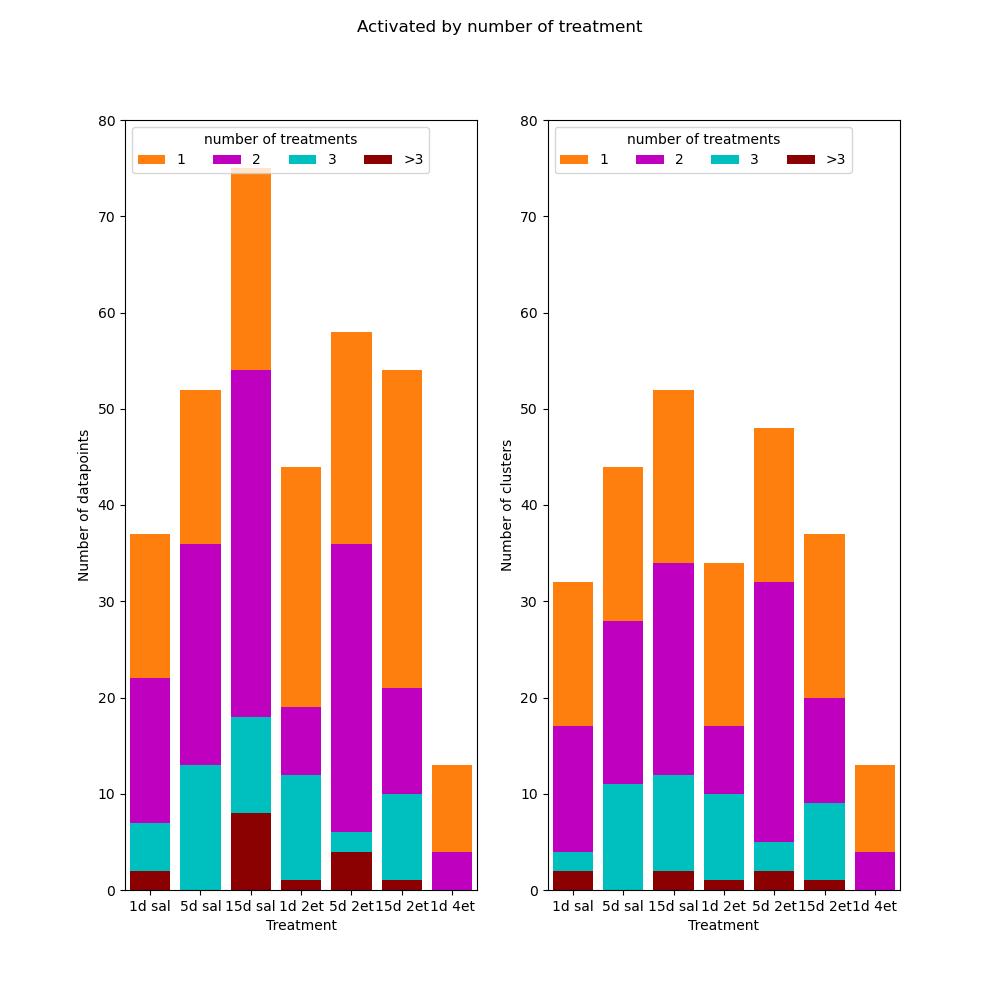

Figure saved: Activated by number of treatment
Saved File Timestamp: (2023-12-04)
file saved to computer folder: C:/Users/Mullo/Documents/output/Figures


In [13]:
#create a graph with x-axis is group ID and y-axis is number of points and number of clusters

FigureTitle= "Activated by number of treatment"
FigureDetail= 'nTreat 2D bargraph'


max_group_number = int(max(setup_RefGroup['Group ID']))
min_group_number= int(min(setup_RefGroup['Group ID']))
fig_nTreat, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10), sharex='all') #Create figure names
ax1.set_ylabel('Number of datapoints')
ax2.set_ylabel('Number of clusters')
ax1.set_xlabel('Treatment') #change so ticks have labels of treatment names
ax2.set_xlabel('Treatment')
ax1.set_xticks(sng_group_included, labels= colorcode_Treat)
ax2.set_xticks(sng_group_included, labels= colorcode_Treat)
fig_nTreat.suptitle(FigureTitle)
ax1.set(xlim=(0.5, max_group_number+0.5), ylim= (0,max(sng_group_npoints)+5))
ax2.set(xlim=(0.5, max_group_number+0.5), ylim= (0,max(sng_group_npoints)+5))

x_value_sng= sng_group_included.tolist()
y_value_spoints= sng_group_npoints
y_value_scluster= sng_group_nclusters
x_value_dbl= dbl_group_included.tolist()
y_value_dpoints= dbl_group_npoints
y_value_dcluster= dbl_group_nclusters
x_value_trp= (trp_group_included.tolist())
y_value_tpoints= trp_group_npoints
y_value_tcluster= trp_group_nclusters
x_value_more= (more_group_included.tolist())
y_value_mpoints= more_group_npoints
y_value_mcluster= more_group_nclusters


ax1.bar(x_value_sng, y_value_spoints, color=treat_1, label="1")
ax2.bar(x_value_sng, y_value_scluster, color=treat_1, label="1")
ax1.bar(x_value_dbl, y_value_dpoints, color=treat_2, label="2")
ax2.bar(x_value_dbl, y_value_dcluster, color=treat_2, label="2")
ax1.bar(x_value_trp, y_value_tpoints, color=treat_3, label="3")
ax2.bar(x_value_trp, y_value_tcluster, color=treat_3, label="3")
ax1.bar(x_value_more, y_value_mpoints, color=treat_plus, label=">3")
ax2.bar(x_value_more, y_value_mcluster, color=treat_plus, label=">3")

ax1.legend(loc="upper left", ncols=4, title="number of treatments")
ax2.legend(loc="upper left", ncols=4,  title="number of treatments")
plt.show()

#________________________________________________________________________
#Save Figure File to path folder
print("Figure saved:", FigureTitle)
print("Saved File Timestamp:", file_date_name)

save_results_to = my_path + output_figures
print("file saved to computer folder:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail+ file_date_name + '.png', dpi = 600)



### Visualize: 3D scatterpoint of centroids, colored by number of treatments and size to number of datapoints in each cluster

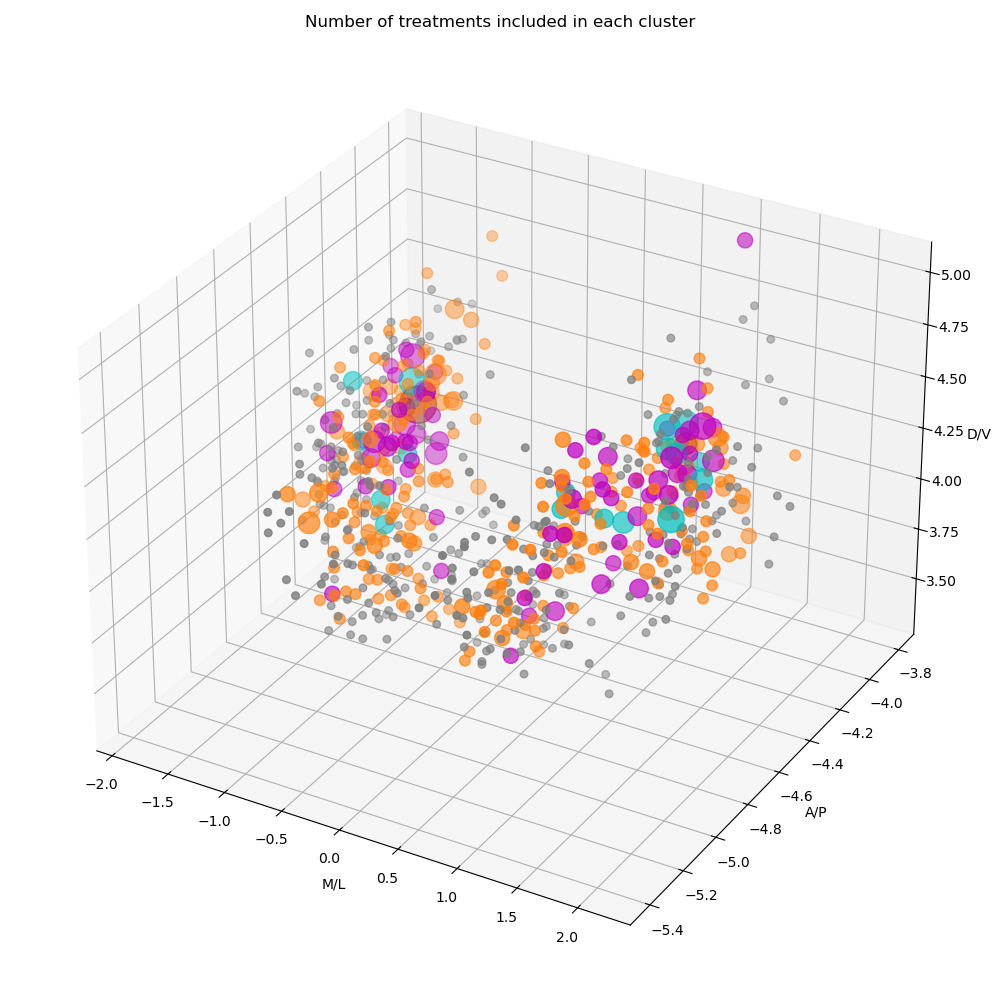

Figure saved: Number of treatments included in each cluster
Saved File Timestamp: (2023-12-04)
file saved to computer folder: C:/Users/Mullo/Documents/output/Figures


In [14]:
FigureTitle = "Number of treatments included in each cluster"
FigureDetail= '3D nTreat with size scale'


#create the figure: 3D centroid visual + color of nTreat + SIZE of n datapoints
marker_set='o'
#ColorScale

#Create base graph of centroid clusters of rep brain 
plt.rcParams["figure.figsize"] = [10, 10]
plt.rcParams["figure.autolayout"] = True
fig_bynumtr = plt.figure()
ax_bnt = fig_bynumtr.add_subplot(projection="3d")


#Define each axis value and plot based on groups
x_repbr= km_cent["ml"].tolist() 
y_repbr= round(km_cent["ap"],2).tolist() 
z_repbr= km_cent["dv"].tolist() 
color_list= full_colorcode
datapoint_size= markersize_checklist
#scale markr size for better viewing:
scale_increase= 30
datapoint_size_scaled=[]
for blossom in range (0, len(datapoint_size)):
    datapoint= datapoint_size[blossom]
    update_point= datapoint*scale_increase
    datapoint_size_scaled.append(update_point)
                      
#set figure axis to correct variable name 
ax_bnt.set_xlabel('M/L')
ax_bnt.set_ylabel('A/P')
ax_bnt.set_zlabel('D/V')
plt.title(FigureTitle)

ax_bnt.scatter(x_repbr, y_repbr, z_repbr, marker=marker_set, c=color_list, s=datapoint_size_scaled)
plt.show()

#making background transparent 
# make the panes transparent
#ax_tc.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax_tc.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
#ax_tc.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# make the grid lines transparent
ax_bnt.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_bnt.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
ax_bnt.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

ax_bnt.view_init(elev=46, azim=-72, roll=0)

#__________________________________________________________________
#Save Figure File to path folder
print("Figure saved:", FigureTitle)
print("Saved File Timestamp:", file_date_name)

save_results_to = my_path + output_figures
print("file saved to computer folder:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)



### Visualize: create 2D crossesction

Figure saved: Distribution of POI neuronal spaces by number of treatments
Saved File Timestamp: (2023-12-04)
file saved to computer folder: C:/Users/Mullo/Documents/output/Figures


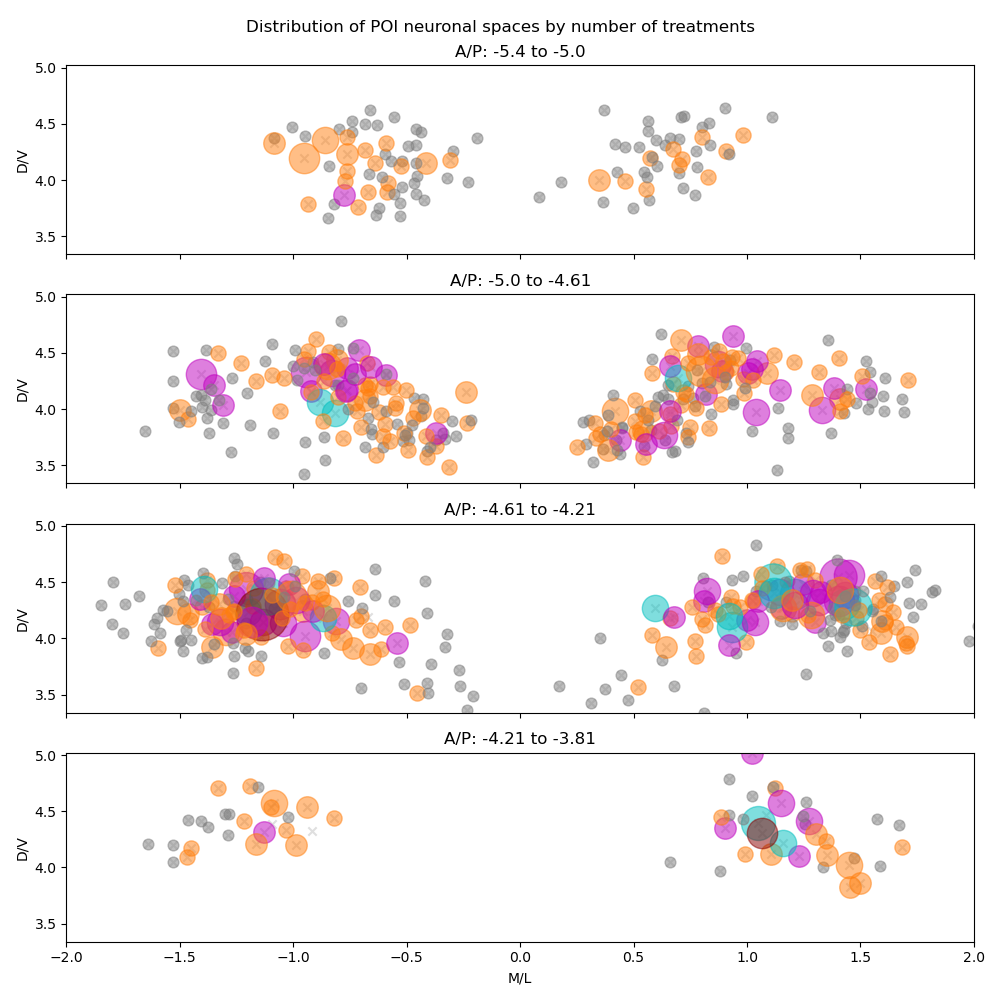

In [15]:
#create figure- specifics
FigureTitle= 'Distribution of POI neuronal spaces by number of treatments'
FigureDetail= '2D nTreat'

fig_2Dtreat, ax_treat= plt.subplots(4,1, sharey='all', sharex='col')
fig_2Dtreat.suptitle(FigureTitle)
marker_set='o'

sct1A=ax_treat[0]
sct1A.set_xlim(min_kmx, max_kmx)
sct1A.set_ylim(min_kmy, max_kmy)
sct1A.set_ylabel('D/V')
sct1A.set_title(f"A/P: {sct1[0]} to {sct1[1]}")
sct2A= ax_treat[1]
sct2A.set_title(f"A/P: {sct2[0]} to {sct2[1]}")
sct2A.set_ylabel('D/V')
sct3A= ax_treat[2]
sct3A.set_ylabel('D/V')
sct3A.set_title(f"A/P: {sct3[0]} to {sct3[1]}")
sct4A= ax_treat[3]
sct4A.set_title(f"A/P: {sct4[0]} to {sct4[1]}")
sct4A.set_ylabel('D/V')
sct4A.set_xlabel('M/L')

#Input dataset to plot 

#FIRST: plot location of representative brain centroids for refernece - #exact same as earlier one
color_input_2='0.5'
alpha_input_2= 0.25
marker_input_2='x'
for tehee in range (0, len(km_cent)):
    plot_ref_section= km_ap[tehee]
    x_ml= km_ml[tehee]
    y_dv= km_dv[tehee]
    for yaha in range (0, len(ap_kmlisted)):
        ref_section= ap_kmlisted[yaha]
        if plot_ref_section == ref_section:
            if (plot_ref_section>= sct1[0]) and (plot_ref_section<= sct1[1]):
                sct1A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
            elif (plot_ref_section>= sct2[0]) and (plot_ref_section<= sct2[1]):
                sct2A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
            elif (plot_ref_section>= sct3[0]) and (plot_ref_section<= sct3[1]):
                sct3A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
            elif (plot_ref_section>= sct4[0]) and (plot_ref_section<= sct4[1]):
                sct4A.scatter(x_ml, y_dv, c=color_input_2, alpha= alpha_input_2, marker=marker_input_2)
        else:
            pass

#graphing variables from earlier-
ml_treat= x_repbr
ap_treat= y_repbr
dv_treat= z_repbr
ap_treat_range= np.unique(ap_treat).tolist()
color_treat= color_list
sizescale_treat= datapoint_size_scaled
sizeOG_treat= datapoint_size

alpha_input_3= 0.5
marker_input_3= marker_set
size_adjust= 2

for wohelo in range (0, len(ap_treat)):
    plot_ref_section= ap_treat[wohelo]
    x_ml= ml_treat[wohelo]
    y_dv= dv_treat[wohelo]
    color_forplot= color_treat[wohelo]
    size_forplot=sizescale_treat[wohelo]* size_adjust
    for foray in range (0, len(ap_treat_range)):
        ref_section= ap_treat_range[foray]
        if plot_ref_section == ref_section:
            if (plot_ref_section>= sct1[0]) and (plot_ref_section<= sct1[1]):
                sct1A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3, s=size_forplot)
            elif (plot_ref_section>= sct2[0]) and (plot_ref_section<= sct2[1]):
                sct2A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3, s=size_forplot)
            elif (plot_ref_section>= sct3[0]) and (plot_ref_section<= sct3[1]):
                sct3A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3, s=size_forplot)
            elif (plot_ref_section>= sct4[0]) and (plot_ref_section<= sct4[1]):
                sct4A.scatter(x_ml, y_dv, c=color_forplot, alpha= alpha_input_3, marker=marker_input_3, s=size_forplot)
        else:
            pass        
plt.figure(fig_2Dtreat)

#__________________________________________________________
#Save Figure File to path folder
print("Figure saved:", FigureTitle)
print("Saved File Timestamp:", file_date_name)
save_results_to = my_path + output_figures
print("file saved to computer folder:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

### TODO: histogram and boxplot distributio of dataset?

### Visualize the most common treatment combination over clusters, to find the level of overlap of different treatments 

#### note- calcualte with csv not code for sake of time 

In [16]:
#the datasets to be refrenced:
#print(single_dataset)
#print(single_wdup)
#print(double_dataset)
#print(double_wdup)
#print(triple_dataset)
#print(triple_wdup)
#print(more_dataset)
#print(more_wdup)

__________________________________________________________________________________________________________________________________________________

### visualize: number of total datapoint (POI) by each ntreat category and treatment combinations
#### TODO: almost complete! Need to fix the labelling of group number combinations to have it as treatment labels for easier identification

Figure saved: Treatment combinations of activated clusters
Saved File Timestamp: (2023-12-04)
file saved to computer folder: C:/Users/Mullo/Documents/output/Figures


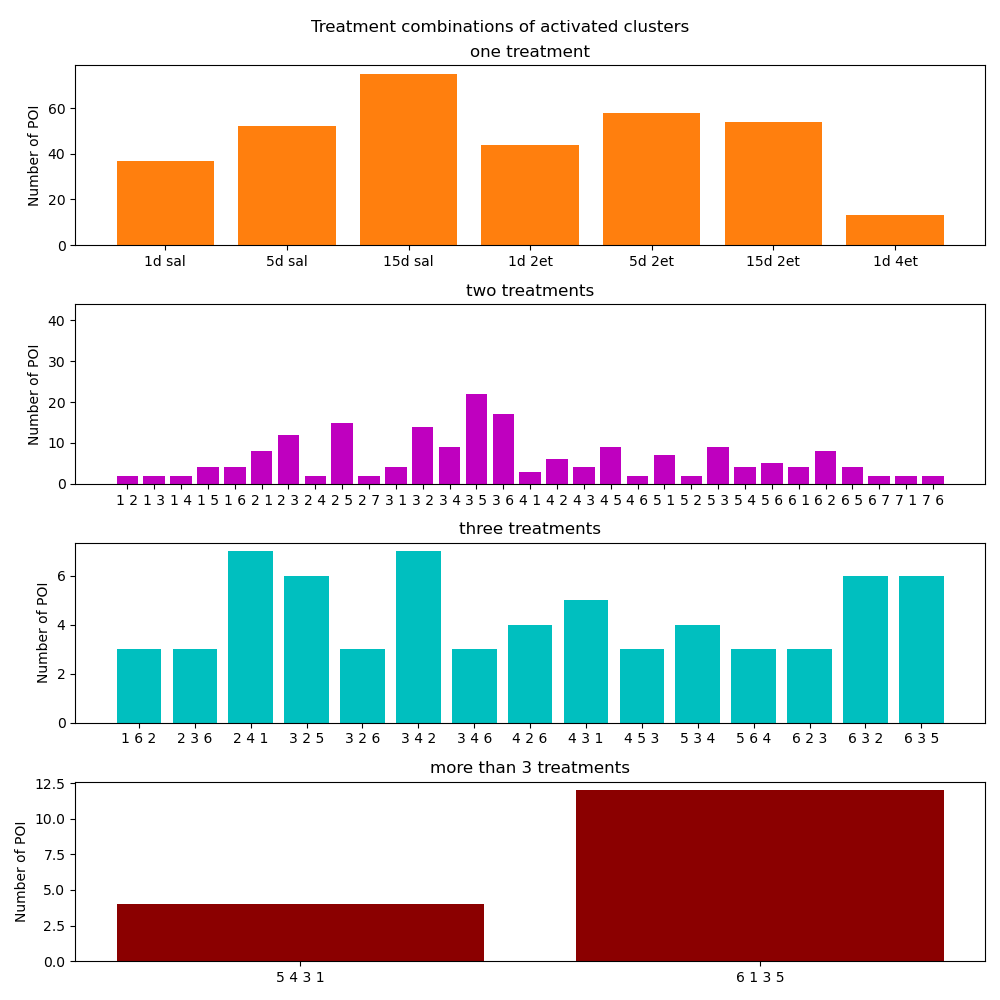

In [17]:
#Make big subplot figure 
FigureTitle="Treatment combinations of activated clusters"
FigureDetail= 'bargraph hist for cross section nTreat'

figure_ntrcombo, ax_ntcombo= plt.subplots(4)
figure_ntrcombo.suptitle(FigureTitle)
single_plot= ax_ntcombo[0]
single_plot.set_title("one treatment")
single_plot.set_ylabel("Number of POI")
double_plot=ax_ntcombo[1]
double_plot.set_title("two treatments")
double_plot.set_ylabel("Number of POI")
triple_plot=ax_ntcombo[2]
triple_plot.set_title("three treatments")
triple_plot.set_ylabel("Number of POI")
more_plot=ax_ntcombo[3]
more_plot.set_title("more than 3 treatments")
more_plot.set_ylabel("Number of POI")

#set color value
single_color= ColorScale[1]
double_color= ColorScale[2]
triple_color= ColorScale[3]
more_color=  ColorScale[4]

#other shared varibales 
#print(setup_RefGroup)
treat_label= setup_RefGroup['Treatment Label'].tolist()
grID_label= setup_RefGroup['Group ID'].tolist()
#####################################################################################
#step1: isolate group labels and convert to type string 
glabel_tostr= double_wdup['Double included groups'].astype('str')

glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))
max_dy= max(summary_count.values())

#step3: plot the measurements in a histogram
double_plot.bar(summary_count.keys(), summary_count.values(), color= double_color)
double_plot.set_ylim(0, 2*(max_dy))

################################################################################
#step1: isolate group labels and convert to type string 
glabel_tostr= triple_wdup['Triple included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))

#step3: plot the measurements in a histogram
triple_plot.bar(summary_count.keys(), summary_count.values(), color= triple_color)

###############################################################################################

#step1: isolate group labels and convert to type string 
glabel_tostr= more_wdup['More included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))

#step3: plot the measurements in a histogram
more_plot.bar(summary_count.keys(), summary_count.values(), color=more_color)

################################################################################################
#step1: isolate group labels and convert to type string 
glabel_tostr= single_wdup['Single included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))
#summary_group= summary_count.keys.tolist()
#print(summary_group)

#lab_axis=[]
#for naming in range (0, len(treat_label)):
    #label_forref= treat_label[naming]
    #group_forref= grID_label[naming]
    #for choices in range (0, len(summary_count.keys())):
        #sanity_check= summary_count.keys()[choices]
        #if group_forref == sanity_check:
            #lab_axis.append(label_forref)
        #else:
            #pass

#step3: plot the measurements in a histogram
single_plot.bar(treat_label, summary_count.values(), color= single_color)
######################################################################################################
plt.figure(figure_ntrcombo)

#Save Figure File to path folder
print("Figure saved:", FigureTitle)
print("Saved File Timestamp:", file_date_name)
save_results_to = my_path + output_figures
print("file saved to computer folder:", save_results_to)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.pdf', dpi = 600)
plt.savefig(save_results_to + my_analysis_file_POI_nocsv + "_ Figure_" + FigureDetail + file_date_name + '.png', dpi = 600)

### Visualize: exact same but number of clusters instead of number of datapoints (better for comparrison)
#### todo- inprove this dataset, since was unable previous
#### The structure is to use the EXACT SAME layout and code as the previous section, except use the variable for number of clusters instead of number of POI

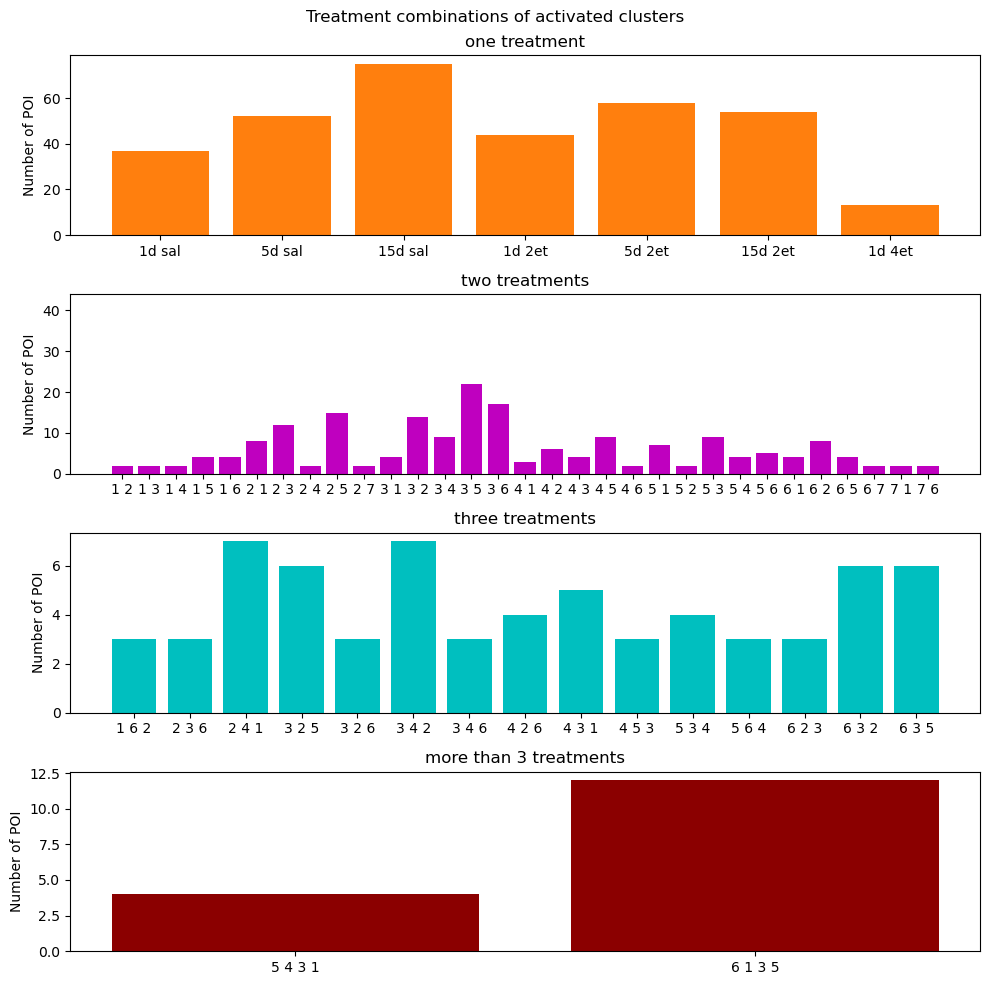

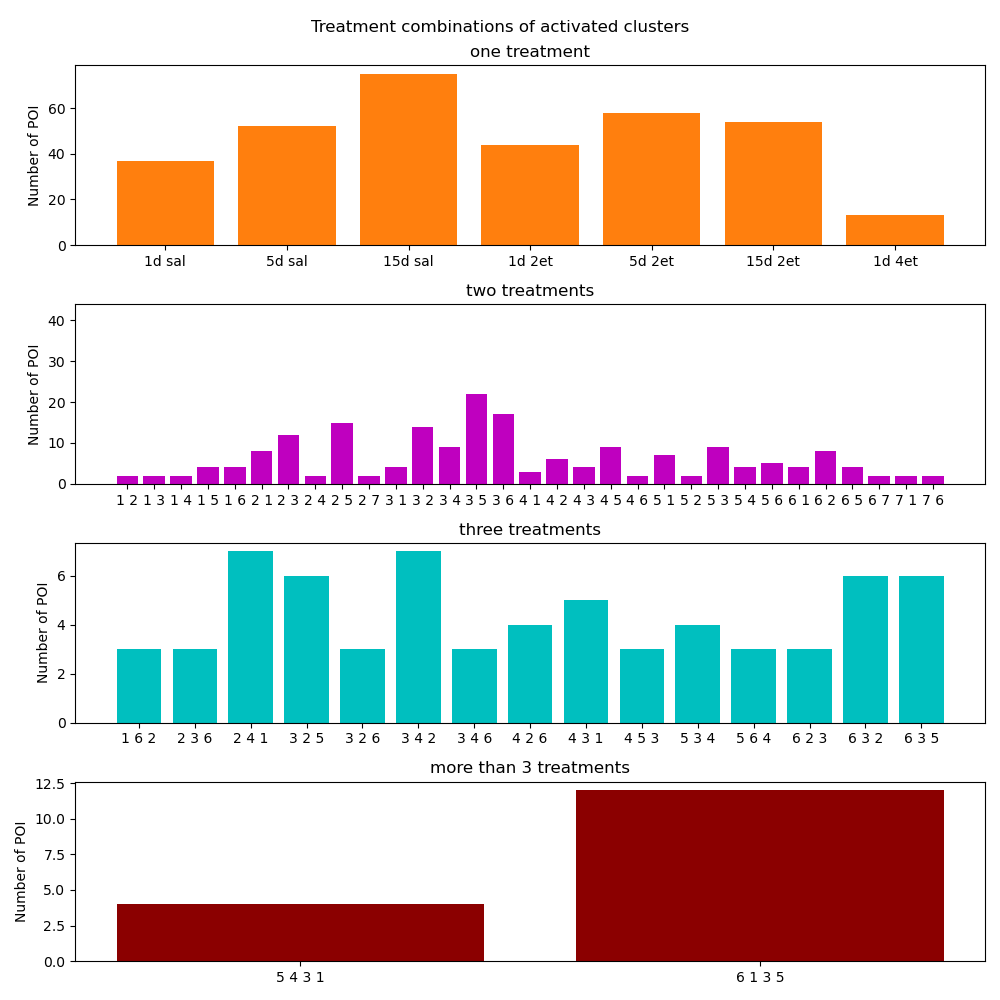

In [18]:
#Make big subplot figure 
FigureTitle="Treatment combinations of activated clusters"


figure_ntrcombo, ax_ntcombo= plt.subplots(4)
figure_ntrcombo.suptitle(FigureTitle)
single_plot= ax_ntcombo[0]
single_plot.set_title("one treatment")
single_plot.set_ylabel("Number of POI")
double_plot=ax_ntcombo[1]
double_plot.set_title("two treatments")
double_plot.set_ylabel("Number of POI")
triple_plot=ax_ntcombo[2]
triple_plot.set_title("three treatments")
triple_plot.set_ylabel("Number of POI")
more_plot=ax_ntcombo[3]
more_plot.set_title("more than 3 treatments")
more_plot.set_ylabel("Number of POI")

#set color value
single_color= ColorScale[1]
double_color= ColorScale[2]
triple_color= ColorScale[3]
more_color=  ColorScale[4]

#other shared varibales 
#print(setup_RefGroup)
treat_label= setup_RefGroup['Treatment Label'].tolist()
grID_label= setup_RefGroup['Group ID'].tolist()
#####################################################################################
#step1: isolate group labels and convert to type string 
glabel_tostr= double_wdup['Double included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))
max_dy= max(summary_count.values())

#step3: plot the measurements in a histogram
double_plot.bar(summary_count.keys(), summary_count.values(), color= double_color)
double_plot.set_ylim(0, 2*(max_dy))

################################################################################
#step1: isolate group labels and convert to type string 
glabel_tostr= triple_wdup['Triple included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))

#step3: plot the measurements in a histogram
triple_plot.bar(summary_count.keys(), summary_count.values(), color= triple_color)

###############################################################################################

#step1: isolate group labels and convert to type string 
glabel_tostr= more_wdup['More included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))

#step3: plot the measurements in a histogram
more_plot.bar(summary_count.keys(), summary_count.values(), color=more_color)

################################################################################################
#step1: isolate group labels and convert to type string 
glabel_tostr= single_wdup['Single included groups'].astype('str')
glabel_clean=[]
for peek in range (0, len(glabel_tostr)):
    value_look= glabel_tostr[peek]
    cleaned= value_look.strip("[]")
    glabel_clean.append(cleaned)
glabel_possible= np.unique(glabel_clean).tolist()
glabel_total_combos= glabel_tostr.nunique()

#step2: quantify the number of combinations and number of occurances
counting_combo=[]
for tick in range (0, len(glabel_tostr)):
    label_compare= glabel_clean[tick]
    for tock in range (0, len(glabel_possible)):
        label_check= glabel_possible[tock]
        if label_compare== label_check:
            value_add=1
            counting_combo.append(label_check)
        else:
            pass
summary_count= Counter(sorted(counting_combo))
#summary_group= summary_count.keys.tolist()
#print(summary_group)

#lab_axis=[]
#for naming in range (0, len(treat_label)):
    #label_forref= treat_label[naming]
    #group_forref= grID_label[naming]
    #for choices in range (0, len(summary_count.keys())):
        #sanity_check= summary_count.keys()[choices]
        #if group_forref == sanity_check:
            #lab_axis.append(label_forref)
        #else:
            #pass

#step3: plot the measurements in a histogram
single_plot.bar(treat_label, summary_count.values(), color= single_color)
######################################################################################################
plt.figure(figure_ntrcombo)


### NOTE- stopped editing at this point, section will need to be completed 
#### Goal of this section is to create the combo for each category so that duplicates are combined (so [1, 4] and [4, 1] are combined not separate), and so that the group numbers are actually listed as group labels 

In [19]:
#making combinations 

#all_2combos=[]
#all_2labelcombo=[]
#for step in range (0, len(grID_label)):
    #option_1= grID_label[step]
    #label_1input= treat_label[step]
    #for skip in range (1, len(grID_label)):
        #option_2= grID_label[skip]
        #label_2input= treat_label[skip]
        #if (option_1 == option_2) :
            #pass
        #elif option_2 < option_1:
            #pass
        #else:
            #all_2combos.append([option_1, option_2])
            #all_2labelcombo.append([label_1input, label_2input])

#make dataframe
#combo_double= pd.DataFrame({"groupID combo":all_2combos, "Treatment label combo":all_2labelcombo})
#print(combo_treat)

#all_3combos=[]
#all_3labelcombo=[]
#for step in range (0, len(grID_label)):
    #option_1= grID_label[step]
    #label_1input= treat_label[step]
    #for skip in range (1, len(grID_label)):
        #option_2= grID_label[skip]
        #label_2input= treat_label[skip]
        #for jump in range (2, len(grID_label)):
            #option_3=grID_label[jump]
            #label_3input= treat_label[jump]
            #if (option_1 == option_2):
                #pass
            #elif option_1 == option_3:
                #pass
            #elif option_2 == option_3:
                #pass
            #elif option_2 < option_1:
                #pass
            #elif option_3 < option_2:
                #pass
            #else:
                #all_3combos.append([option_1, option_2, option_3])
                #all_3labelcombo.append([label_1input, label_2input, label_3input])
#make dataframe
#combo_triple= pd.DataFrame({"groupID combo":all_3combos, "Treatment label combo":all_3labelcombo})
#print(combo_triple)

#glabel_new= double_wdup['Double included groups'].tolist()

#for wow in range (0, len(all_combos)):
    #input_combo= all_combos[wow]
    #input_labelcombo= all_labelcombo[wow]
    #for whoa in range (0, len(glabel_new)):
        #compare_combo= glabel_new[whoa]
        #if input_combo == compare_combo:
            #pass
        #else:
            #pass
